# Batting Average Prediction Model

This notebook provides a model to predict a player's 2018 final batting average using stats from March/April 2018. The model will be created using a prior year's early season to post season data comparison.

The prediction model will use the April 2017 data (there were no games in March 2017, opening day was 4/2/17) and final batting average data from the 2017 season to create a linear regression model. The March/April data from the 2018 season will then be applied to this model to predict the final batting average for the 2018 season.

The 2017 data uses the labels "MarApr" even though there is no data from March 2017. The "MarApr" label was used to keep the column names consistant with the 2018 data.

The data was obtained from Baseball Savant Statcast Search:
https://baseballsavant.mlb.com/statcast_search

In [1]:
# Import dependcies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Upload csv files data
batting2018 = pd.read_csv("batting2018.csv")
batting2017 = pd.read_csv("batting2017.csv")

<H2>Explore the data</H2>

In [3]:
# Display the 2017 column names
batting2017.columns

Index(['Name', 'MarApr_PA', 'MarApr_AB', 'MarApr_H', 'MarApr_HR', 'MarApr_K%',
       'MarApr_BB%', 'MarApr_BABIP', 'MarApr_ISO', 'MarApr_AVG', 'MarApr_SLG',
       'MarApr_OBP', 'FullSeason_AVG'],
      dtype='object')

In [4]:
# Display the 2018 column names
batting2018.columns

Index(['Name', 'MarApr_PA', 'MarApr_AB', 'MarApr_H', 'MarApr_HR', 'MarApr_K%',
       'MarApr_BB%', 'MarApr_BABIP', 'MarApr_ISO', 'MarApr_AVG', 'MarApr_SLG',
       'MarApr_OBP', 'FullSeason_AVG'],
      dtype='object')

In [5]:
# Display 2017 datatypes
batting2017.dtypes

Name               object
MarApr_PA           int64
MarApr_AB           int64
MarApr_H            int64
MarApr_HR           int64
MarApr_K%         float64
MarApr_BB%        float64
MarApr_BABIP      float64
MarApr_ISO        float64
MarApr_AVG        float64
MarApr_SLG        float64
MarApr_OBP        float64
FullSeason_AVG    float64
dtype: object

In [6]:
# Display 2018 datatypes
batting2018.dtypes

Name               object
MarApr_PA         float64
MarApr_AB         float64
MarApr_H          float64
MarApr_HR         float64
MarApr_K%         float64
MarApr_BB%        float64
MarApr_BABIP      float64
MarApr_ISO        float64
MarApr_AVG        float64
MarApr_SLG        float64
MarApr_OBP        float64
FullSeason_AVG    float64
dtype: object

In [7]:
# Set the minimum number of plate appearances
min_PA = 30

In [8]:
# Only include players with the minumum number of plate appearances
batting2017 = batting2017.loc[batting2017["MarApr_PA"]>=min_PA]
batting2018 = batting2018.loc[batting2018["MarApr_PA"]>=min_PA]

In [9]:
# Check if there are missing values in the 2017 data
batting2017.isnull().sum()

Name              0
MarApr_PA         0
MarApr_AB         0
MarApr_H          0
MarApr_HR         0
MarApr_K%         0
MarApr_BB%        7
MarApr_BABIP      0
MarApr_ISO        0
MarApr_AVG        0
MarApr_SLG        0
MarApr_OBP        0
FullSeason_AVG    0
dtype: int64

In [10]:
# Remove the players with missing data
batting2017 = batting2017.dropna()
batting2017.isnull().sum()

Name              0
MarApr_PA         0
MarApr_AB         0
MarApr_H          0
MarApr_HR         0
MarApr_K%         0
MarApr_BB%        0
MarApr_BABIP      0
MarApr_ISO        0
MarApr_AVG        0
MarApr_SLG        0
MarApr_OBP        0
FullSeason_AVG    0
dtype: int64

In [11]:
# Check if there are missing values in 2018 data
batting2018.isnull().sum()

Name              0
MarApr_PA         0
MarApr_AB         0
MarApr_H          0
MarApr_HR         0
MarApr_K%         0
MarApr_BB%        5
MarApr_BABIP      0
MarApr_ISO        0
MarApr_AVG        0
MarApr_SLG        0
MarApr_OBP        0
FullSeason_AVG    0
dtype: int64

In [12]:
# Remove the players with missing data
batting2018 = batting2018.dropna()
batting2018.isnull().sum()

Name              0
MarApr_PA         0
MarApr_AB         0
MarApr_H          0
MarApr_HR         0
MarApr_K%         0
MarApr_BB%        0
MarApr_BABIP      0
MarApr_ISO        0
MarApr_AVG        0
MarApr_SLG        0
MarApr_OBP        0
FullSeason_AVG    0
dtype: int64

In [13]:
# Check the number of players in the data sets
print(len(batting2017), "players in the 2017 data set")
print(len(batting2018), "players in the 2018 data set")

329 players in the 2017 data set
365 players in the 2018 data set


<H2>Check for relationships between variables</H2>

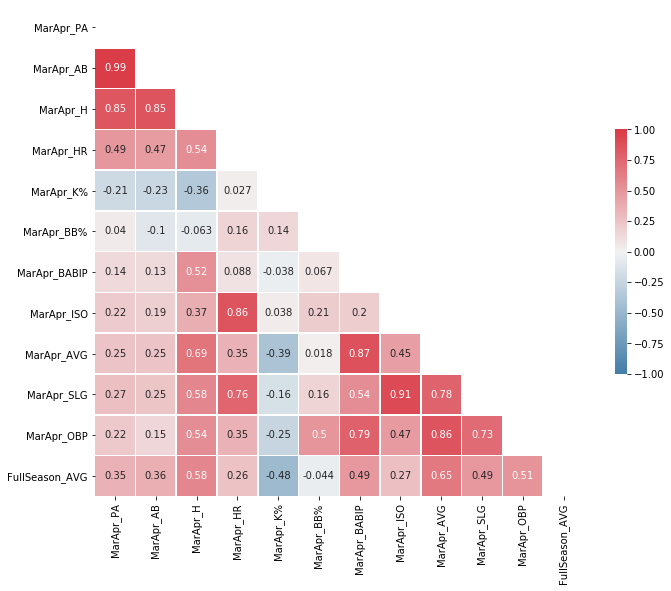

In [14]:
# Take a look at visial representation of correlation between variables
corr = batting2017.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# Code used from:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

The above image shows the correlations between the input variables. The variable pairs that are close to 1 or -1 can have a negative affect on the model (for example AB/PA). Including variables that are highly correleated to eachother will cause the model to be less accurate due to the multicollinearity between the variables.

The most important variables will need to be selected to increase the reliability of the model.

<H2>Find the optimal combination of features (variables) to make the best model</H2>

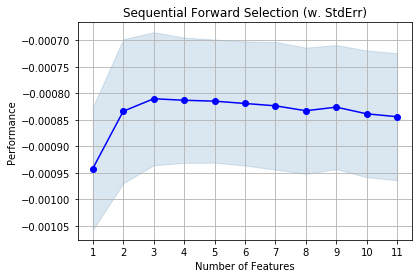

Best score: 0.0008103293000644871
Best subset: ['MarApr_AB', 'MarApr_K%', 'MarApr_AVG']


In [15]:
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

y2017 = batting2017["FullSeason_AVG"]
X2017 = batting2017.drop(["Name", "FullSeason_AVG"], axis=1)

regr = linear_model.LinearRegression()

# Split the data into test and training sets with 20% of data as test set
X_train2017, X_test2017, y_train2017, y_test2017 = train_test_split(X2017, y2017, test_size=0.2, random_state=1)

sfs = SFS(regr, 
          k_features=(1, len(X2017.columns)),
          forward=True, 
          floating=False,
          verbose=0,
          scoring='neg_mean_squared_error',
          cv=10)

sfs = sfs.fit(X_train2017, y_train2017)

fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()
best_stats = list(sfs.k_feature_names_)

print('Best score:', sfs.k_score_ * (-1))
print('Best subset:', best_stats)

# http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

Using a forward sequential feature selector, AB, K%, and AVG were found to be the best combination of variables. This is represented on the graph above. The highest point of the graph (indiciating the lowest error) is where 3 features are used in the model.

<H3>Check for relationships between the three selected variables (AB, K%, AVG)</H3>

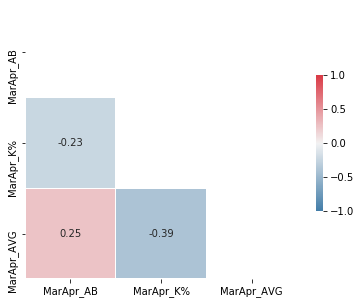

In [16]:
# Take a look at visial representation of correlation between variables
corr = batting2017[best_stats].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# Code used from:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

The variables in this set are not highly correlated with each other. This will be an acceptable coolection of variables to use as the prediction model.

<H3>Train the model</H3>

In [17]:
y2017 = batting2017["FullSeason_AVG"]
X2017 = batting2017[best_stats]
X2018 = batting2018[best_stats]

In [18]:
# Create the linear regression model
regr = linear_model.LinearRegression()

# The data will be split into testing and training sets 
    
# Split the data into test and training sets with 20% of data as test set
X_train2017, X_test2017, y_train2017, y_test2017 = train_test_split(X2017, y2017, test_size=0.2, random_state=1)
    
# Make the linear regression model
regr.fit(X_train2017, y_train2017)

LinearRegression()

<H3>Test the model</H3>

In [19]:
# Calulate the predicted results
predicted_AVG2017 = regr.predict(X_test2017)
print("Training data r-squared:", regr.score(X_train2017, y_train2017))
print("Test data r-squared:", regr.score(X_test2017, y_test2017))
mse = mean_squared_error(y_test2017, predicted_AVG2017)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Training data r-squared: 0.48957876838919656
Test data r-squared: 0.5565180863280633
Root Mean Squared Error: 0.029444018573431353


For comparison I will train and test a model using all of the variables.

In [20]:
# Model including all of the varaibles
y2017All = batting2017["FullSeason_AVG"]
X2017All = batting2017.drop(columns=["Name", "FullSeason_AVG"])
X2018All = batting2018.drop(columns=["Name", "FullSeason_AVG"])

# Create the linear regression model
regrAll = linear_model.LinearRegression()

# The data will be split into testing and training sets 
    
# Split the data into test and training sets with 20% of data as test set
X_train2017, X_test2017, y_train2017, y_test2017 = train_test_split(X2017All, y2017All, test_size=0.2, random_state=1)
    
# Make the linear regression model
regrAll.fit(X_train2017, y_train2017)

# Calulate the predicted results
predicted_AVG2017 = regrAll.predict(X_test2017)
print("Training data r-squared:", regrAll.score(X_train2017, y_train2017))
print("Test data r-squared:", regrAll.score(X_test2017, y_test2017))
mse = mean_squared_error(y_test2017, predicted_AVG2017)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Training data r-squared: 0.5081029122210063
Test data r-squared: 0.5315088312223437
Root Mean Squared Error: 0.030262850395790665


This selected combination of features (AB, K%, and AVG) has a lower root mean squared error and higher testing r-squared value than the model using all of the variables.

Selecting only the AB, K%, and AVG variables produces a more accurate model than using all of the variables.

<H3>Predict the 2018 end of season batting average</H3>

In [21]:
# Calulate the predicted results
predicted_AVG = regr.predict(X2018)
results = batting2018[["Name", "FullSeason_AVG"]]
results["Predicted_AVG"] = predicted_AVG

# Calculate percent error
results["%_Error"] = round(100 * (results["FullSeason_AVG"] - results["Predicted_AVG"]).abs()/results["FullSeason_AVG"],2)

# Download csv results file
results.to_csv("Results.csv")

results

Name  FullSeason_AVG  Predicted_AVG  %_Error
2          Judge, Aaron           0.278       0.268772     3.32
3        Semien, Marcus           0.255       0.270240     5.98
4          Pirela, Jose           0.249       0.271741     9.13
5      Hernandez, Cesar           0.253       0.269217     6.41
6        Gardner, Brett           0.236       0.248906     5.47
..                  ...             ...            ...      ...
367          Muncy, Max           0.263       0.204552    22.22
369      Maxwell, Bruce           0.182       0.212577    16.80
378  Culberson, Charlie           0.270       0.177535    34.25
381        Sucre, Jesús           0.209       0.258679    23.77
386         Hicks, John           0.260       0.203406    21.77

[365 rows x 4 columns]

In [22]:
print("The average % error is: " + str(round(results["%_Error"].mean(),2)) + "%")

print("The range of % errors is: " + str(round(results["%_Error"].min(),2)) + "% - " + 
      str(round(results["%_Error"].max(),2)) + "%")

The average % error is: 10.59%
The range of % errors is: 0.01% - 63.09%


While some of the batting average predictions were very close (0.01% error), others were not as close to the correct average (63.09% error). There are several factors that can contribute to the wide range of % errors in the prediction model.

This is mainly due to the fact that no two seasons are alike. A players previous season is not necessarlily an indicator for future performance. There are several factors that can change between seasons and throughout the course of a season. Some of these factors include improved performance, injury, and off field issues/distractions.

A model accounting for offseason and inseason training activities in addition to the previous season data may lead to a more accurate prediction.